In [1]:
"""
The purpose of this script to create a refined patient record data structure

Steps:
1. Open record as dict with wfdb.rdrecord
2. get patient location (simple)
3. for each of the desired signals present (3 ABP + HR):
    a. determine if present
    b. get signal
    c. process signal
        I. get start, end of signal
        II. detect gaps of one hour or more based on sf, store these indices
        III. Interpolate over nan values
        IV. Run Artifact detection
        V. Set artifacts to nan
        VI. interpolate over artifacts
        VII. Check for gaps of one hour or more?
        VIII. output cleaned signal and indices
4. dump the signals and record to a new pickle object

"""


signalDict = {
'ABP Dias':['ABPDias','ABP DIAS','ART DIAS','ABP Dias','ART Dias','AOBP Dias','Ao DIAS'],
'ABP Mean':['ABPMean','ABP MEAN','ART MEAN','ABP Mean','ART Mean','AOBP Mean','Ao MEAN'],
'ABP Sys':['ABPSys','ABP SYS','ART SYS','ABP Sys','ART Sys','AOBP Sys','Ao SYS'],
'HR':['HR']
}


def getSignal(signal,record,signalsDict):

    variations = signalsDict[signal]
    for variation in variations:
        if variation in record['sig_name']:
            ind = record['sig_name'].index(variation)
            units = record['units'][ind]
            return record['p_signal'][:,ind],units

    return None,None  

In [2]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import math
from collections import defaultdict
import wfdb

import pickle


#example patient record
file = '/Users/Arcrank/Documents/Work/mimic3wdb/matched_numeric/p03/p032447/p032447-2170-04-17-16-46n'
recordFile = wfdb.rdrecord(file)
record = recordFile.__dict__

# for key in record:
#     print(key)
    
# a ,b = getSignal('ABP Sys',record,signalDict)
# for i,v in enumerate(a):
#     print(i,v)

In [3]:

# # def replaceNansTails(signal,sig_len,start_end):
# #     start = start_end[0]
# #     end = start_end[1]
# #     outputsignal = signal.copy()
# #     for i in range(sig_len):
# #         if i < start or i > end:
# #             outputsignal[i] == np.nan
# #     return outputsignal


# def detectHRArtifact(signal):
#     """
#     Parameters: < 20
#                 > 220
#     """

#     indices = []
    
#     for index, signalValue in enumerate(signal):
        
#         if signalValue < 20 or signalValue > 220:
#             indices.append(index)
#     print(indices)     
#     return indices




# def detectABPArtifact(sys,dias,mean,fs):
#     """
        
#     NEED TO DETERMINE HOW TO DOWNSAMPLE 1HZ SIGNAL
#     Using a similar approach then Sun et al. 
    
#     Condition 1: SBP >= 300 or SBP <= 20
#     Condition 2: SBP - DBP <= 5
#                  SBP - DBP > 200
    
#     Condition 3: DBP <=5 or DBP >= 225
    
#     Condition 4: BP beat-to beat > 20mmhg for Ps,Pd, mean
    
#     Condition 5: += 80 mmhg / min change
    
#     Note: not complete for 1Hz condition 5, need to determine how to downsample to 1/60Hz
#     """


    
#     sysIndices =[]
#     diasIndices = []
#     meanIndices = []
    
#     for index,sysSignalValue in enumerate(sys):
#         # Condition 1
#         if sysSignalValue >= 300 or sysSignalValue <= 20:
#             sysIndices.append(index)
#             #print('sys max')
#         # Condition 2    
#         if sysSignalValue - dias[index] <= 5 or sysSignalValue - dias[index] > 200:
#             #print('cond 2',sysSignalValue,dias[index])
#             sysIndices.append(index)
#             diasIndices.append(index)
#             meanIndices.append(index)
#     # Condition 3        
#     for index, diasSignalValue in enumerate(dias):
        
#         if diasSignalValue <=5 or diasSignalValue >= 225:
#             #print('dias cond',diasSignalValue)
#             diasIndices.append(index)
            
            
            
            
            
#     def detectDelta(signal,delta):
#         flaggedsig = []
#         for index, sigVal in enumerate(signal[:-1]):
#             if not np.isnan(sigVal) and not np.isnan(signal[index+1]):
#                 if abs(signal[index+1] - sigVal) > delta:
#                     #flaggedsig.append(index)
#                     flaggedsig.append(index+1)
#         return flaggedsig
    
    
#     if round(fs,4) == .0167:
#         for index, signal in enumerate(sys[:-1]):
#             # Sys
        
         
#             if not np.isnan(signal) and not np.isnan(sys[index+1]):
#                 if abs(sys[index+1]-signal) > 80:
#                     sysIndices.append(index+1)
#             # Dias        
#             if not np.isnan(dias[index]) and not np.isnan(dias[index+1]):
#                 if abs(dias[index+1]-dias[index]) > 80:
#                     diasIndices.append(index+1)
#             # Mean        
#             if not np.isnan(mean[index]) and not np.isnan(mean[index+1]):
#                 if abs(mean[index+1]-mean[index]) > 80:        
#                     meanIndices.append(index+1)
                    
    
    
#     return sysIndices,diasIndices,meanIndices








In [4]:

        

class newRecord:
    def __init__(self, record):

        # Immediately available information
        self.record_name = record['record_name']
        self.fs = record['fs']
        self.counter_freq = record['counter_freq']
        self.sig_len = record['sig_len']
        self.base_time = record['base_time']
        self.base_date = record['base_date']
        self.base_datetime = record['base_datetime']

        # Derived Information

        def getLocation(record):
            """
            Pulls location from comments field
            """
            comments = record['comments']
            for c in comments:
                if c.lower().startswith('location:'):
                    _, location = c.split(':')

                    return (location.strip())
            return None

        self.location = getLocation(record)

        def detectHRArtifact(signal):
            """
            Parameters: < 20
                        > 220
            """

            indices = []

            for index, signalValue in enumerate(signal):

                if signalValue < 20 or signalValue > 220:
                    indices.append(index)
            # print(indices)
            return indices

        def detectABPArtifact(sys, dias, mean, fs):
            """

            NEED TO DETERMINE HOW TO DOWNSAMPLE 1HZ SIGNAL
            Using a similar approach then Sun et al.

            Condition 1: SBP >= 300 or SBP <= 20
            Condition 2: SBP - DBP <= 5
                         SBP - DBP > 200

            Condition 3: DBP <=5 or DBP >= 225

            Condition 4: BP beat-to beat > 20mmhg for Ps,Pd, mean

            Condition 5: += 80 mmhg / min change

            Note: not complete for 1Hz condition 5, need to determine how to downsample to 1/60Hz
            """

            sysIndices = []
            diasIndices = []
            meanIndices = []

            for index, sysSignalValue in enumerate(sys):
                # Condition 1
                if sysSignalValue >= 300 or sysSignalValue <= 20:
                    sysIndices.append(index)
                    # print('sys max')
                # Condition 2
                if sysSignalValue - dias[index] <= 5 or sysSignalValue - dias[index] > 200:
                    # print('cond 2',sysSignalValue,dias[index])
                    sysIndices.append(index)
                    diasIndices.append(index)
                    meanIndices.append(index)
            # Condition 3
            for index, diasSignalValue in enumerate(dias):

                if diasSignalValue <= 5 or diasSignalValue >= 225:
                    # print('dias cond',diasSignalValue)
                    diasIndices.append(index)

            def detectDelta(signal, delta):
                flaggedsig = []
                for index, sigVal in enumerate(signal[:-1]):
                    if not np.isnan(sigVal) and not np.isnan(signal[index + 1]):
                        if abs(signal[index + 1] - sigVal) > delta:
                            # flaggedsig.append(index)
                            flaggedsig.append(index + 1)
                return flaggedsig

            if round(fs, 4) == .0167:
                for index, signal in enumerate(sys[:-1]):
                    # Sys


                    if not np.isnan(signal) and not np.isnan(sys[index + 1]):
                        if abs(sys[index + 1] - signal) > 80:
                            sysIndices.append(index + 1)
                    # Dias
                    if not np.isnan(dias[index]) and not np.isnan(dias[index + 1]):
                        if abs(dias[index + 1] - dias[index]) > 80:
                            diasIndices.append(index + 1)
                    # Mean
                    if not np.isnan(mean[index]) and not np.isnan(mean[index + 1]):
                        if abs(mean[index + 1] - mean[index]) > 80:
                            meanIndices.append(index + 1)

            return sysIndices, diasIndices, meanIndices

        def getSignal(signal, record, signalsDict):

            variations = signalsDict[signal]
            for variation in variations:
                if variation in record['sig_name']:
                    ind = record['sig_name'].index(variation)
                    units = record['units'][ind]
                    return record['p_signal'][:, ind], units

            return None, None

        def startOfSignal(signal):
            for index, value in enumerate(signal):
                if not np.isnan(value):
                    return index

            return None

        def endOfSignal(signal):
            for index, sample in enumerate(signal[::-1]):
                if not np.isnan(sample):
                    return len(signal) - index
            return None

        def processABPSignal(signal, indices):
            # noNans = interpolateNans(signal)
            noArtifacts = artifact_to_nan(signal, indices)
            correctedSignal = interpolateNans(noArtifacts)
            return correctedSignal



            # Signal Processing

        def get_time_frames(signal):

            start = startOfSignal(signal)
            end = endOfSignal(signal)

            timeframes = detectGaps(signal, start, end, self.fs)

            return timeframes

        def get_start_end(signal):
            start = startOfSignal(signal)
            end = endOfSignal(signal)
            return (start, end)

        def artifact_to_nan(vector, indices):
            c = vector.copy()
            for value in indices:
                c[value] = np.nan

            return c

        def replaceNansTails(signal, sig_len, start_end):
            start = start_end[0]
            end = start_end[1]
            outputsignal = signal.copy()
            for i in range(sig_len):

                if i < start or i > end:
                    a = outputsignal[i]
                    outputsignal[i] = np.nan

            return outputsignal

        def interpolateNans(signal):
            def nan_helper(y):
                return np.isnan(y), lambda z: z.nonzero()[0]

            nans, x = nan_helper(signal)
            signal[nans] = np.interp(x(nans), x(~nans), signal[~nans])

            return signal

        def processHRSignal(signal):
            # noNans = interpolateNans(signal)
            noArtifacts = artifact_to_nan(signal, detectHRArtifact(signal))

            correctedSignal = interpolateNans(noArtifacts)
            return correctedSignal




            # self.units = record['units']

        def detectGaps(signal, start, end, fs):

            hourGap = 60 if round(fs, 4) == .0167 else 3600 if fs == 1 else None

            if hourGap is None:
                return "Fatal error wrong frequency"

            frames = []
            nanframes = []
            cache = 0
            placeholderStart = start
            placeholderEnd = start
            nanstart = start
            nanend = start
            # Only look at frame from start to end of signal, excluding trailing and leading NaNs
            for index, value in enumerate(signal[start:end]):

                if np.isnan(value):
                    # means we are currently in a gap
                    cache += 1
                    nanend = index
                if not np.isnan(value):
                    # value is present, check if the cache is greater than an hour, if so, add the start and end indices
                    if cache > hourGap:
                        # print('found gap at',index,value)
                        frames.append((placeholderStart, placeholderEnd + 1))
                        nanframes.append((nanstart,nanend))
                        cache = 0
                        placeholderStart = index
                        nanstart = index

                    else:
                        placeholderEnd = index
                        cache = 0

            frames.append((placeholderStart, placeholderEnd + 1))

            if frames != []:
                return frames
            else:
                return [(start, end)]

        def nan_out_gaps(signal, goodTimes):
            copy = signal.copy()

            l = len(signal)

            goodSample = []
            for s, e in goodTimes:
                goodSample.append([i for i in range(s, e)])

            goodSamples = [item for sublist in goodSample for item in sublist]

            badIndices = []
            for i in range(l):
                if i not in goodSamples:
                    badIndices.append(i)

            for sample in badIndices:
                copy[sample] = np.nan

            return copy

        #         processSignal()signal, start/end/timeframes,arfitactdetector

        #         interpolateNans():
        #         detectABPartifact
        #         interpolateNans():
        #         Nanout gaps
        #         nan out tails
        #         return signal

        #         def processSignal(signal,start_end,timeframes,artifact_alg):
        #             signal = interpolateNans(signal)





        # Get raw signal
        self.rawABPsys, self.ABPsysUnits = getSignal('ABP Sys', record, signalDict)
        self.rawABPdias, self.ABPdiasUnits = getSignal('ABP Dias', record, signalDict)
        self.rawABPmean, self.ABPmeanUnits = getSignal('ABP Mean', record, signalDict)

        self.rawHR, self.HRUnits = getSignal('HR', record, signalDict)

        # get start/end of signal
        self.ABPsys_se = get_start_end(self.rawABPsys)
        self.ABPdias_se = get_start_end(self.rawABPdias)
        self.ABPmean_se = get_start_end(self.rawABPmean)
        self.HR_se = get_start_end(self.rawHR)

        self.ABPsystf = get_time_frames(self.rawABPsys)
        self.ABPdiastf = get_time_frames(self.rawABPdias)
        self.ABPmeantf = get_time_frames(self.rawABPmean)
        self.HRtf = get_time_frames(self.rawHR)

        # interpolate over nans
        #         self.abpsys1 = interpolateNans(self.rawABPsys.copy())
        #         self.abpdias1 = interpolateNans(self.rawABPdias.copy())
        #         self.abpmean1 = interpolateNans(self.rawABPmean.copy())
        self.HR1 = interpolateNans(self.rawHR)

        def processABP(sys, dias, mean, fs):
            abpsys1 = interpolateNans(sys)
            abpdias1 = interpolateNans(dias)
            abpmean1 = interpolateNans(mean)

            # detect artifacts
            sysIndices, diasIndices, meanIndices = detectABPArtifact(abpsys1, abpdias1, abpmean1, fs)

            abpsys2 = processABPSignal(abpsys1, sysIndices)
            abpdias2 = processABPSignal(abpdias1, diasIndices)
            abpmean2 = processABPSignal(abpmean1, meanIndices)

            abpsys2 = nan_out_gaps(abpsys2, self.ABPsystf)
            abpdias2 = nan_out_gaps(abpdias2, self.ABPdiastf)
            abpmean2 = nan_out_gaps(abpmean2, self.ABPmeantf)

            ABPsys = replaceNansTails(abpsys2, self.sig_len, self.ABPsys_se)
            ABPdias = replaceNansTails(abpdias2, self.sig_len, self.ABPdias_se)
            ABPmean = replaceNansTails(abpmean2, self.sig_len, self.ABPmean_se)
            return ABPsys, ABPdias, ABPmean

        self.ABPsys, self.ABPdias, self.ABPmean = processABP(self.rawABPsys.copy(), self.rawABPdias.copy(),
                                                             self.rawABPmean.copy(), self.fs)

        ######### HR #########


        self.HR = processHRSignal(self.rawHR)


        ######################

    #         self.ABP= [(self.ABPsystf,self.ABPsys),(self.ABPdiastf,self.ABPdias),(self.ABPmeantf,self.ABPmean)]

    #     def __setstate__(self, state):
    #         self.__dict__.update(state)

    def printName(self):
        print(self.record_name)
        return None

    def printHR(self):
        for x in self.HRtf:
            s, e = x


            
            
# #np.nditer(a.T):


# c = newRecord(record)
# c.printName()
# ae = c.record_name + '.pkl'

# b = c.__dict__

# for k in b:
#     print(k,b[k])
    
# a = b['rawABPmean']
# e = b['ABPsys']

# for k in b:
#     print(k,b[k])



# import _pickle
    
# with open(ae, 'wb') as output:

#     pickle.dump(c, output)

# for i,v in enumerate(a):
#     print(i,v)

[(0, 5602), (5687, 18207)]
[(0, 5602), (5687, 18207)]
[(0, 18207)]
[(0, 27410)]
[5602, 12520] [5602, 12520] [18207] [27410]


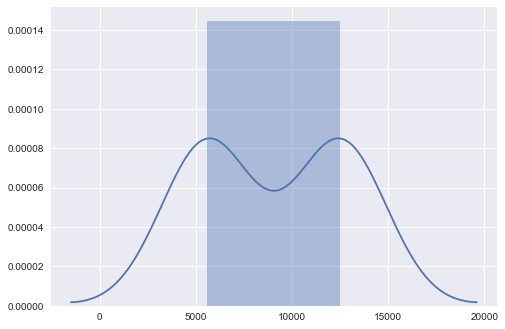

In [7]:
with open('p032447-2170-04-17-16-46n.pkl', 'rb') as f:
     record = pickle.load(f)

record = record.__dict__
# print(record)
# for k in record:
#     print(k)
    
    
# print(record['fs'])
fs = record['fs']
# print(record['ABPsystf'])

sysmin = []
diasmin = []
meanmin = []
hrmin = []

syssec =[]
diassec =[]
meansec =[]
hrsec = []


def getSigLen(signal,record):
    
    tf = signal + 'tf'

    timeframes = record[tf]
    print(timeframes)
    siglens = []
    for start,end in timeframes:
        length  = end-start
        siglens.append(length)
        
    return siglens

signals = ['ABPsys','ABPdias','ABPmean','HR']

if fs < 1:
    sysmin.append(getSigLen('ABPsys',record))
    diasmin.append(getSigLen('ABPdias',record))
    meanmin.append(getSigLen('ABPmean',record))
    hrmin.append(getSigLen('HR',record))
  
else:
    syssec.append(getSigLen('ABPsys',record))
    diassec.append(getSigLen('ABPdias',record))
    meansec.append(getSigLen('ABPmean',record))
    hrsec.append(getSigLen('HR',record))
     
    
    

SysMin = [item for sublist in sysmin for item in sublist]
DiasMin= [item for sublist in diasmin for item in sublist]
MeanMin = [item for sublist in meanmin for item in sublist]
HRMin = [item for sublist in hrmin for item in sublist]

print(SysMin,DiasMin,MeanMin,HRMin)
import seaborn as sns
sns.distplot(SysMin);

In [6]:


def teststartOfSignal(signal):
    for index,value in enumerate(signal):
        if not np.isnan(value):
            return index

    return None


def testendOfSignal(signal):
    for index, sample in enumerate(signal[::-1]):
        if not np.isnan(sample):
            return len(signal) - index
    return None


def testdetectgaps(signal,start,end,fs):
        
    hourGap = 60 if round(fs,4) == .0167 else 3600 if fs == 1 else None
        
    if hourGap is None:
        return "Fatal error wrong frequency"
        
    frames = []
    cache = 0
    placeholderStart = start
    placeholderEnd = start
    # Only look at frame from start to end of signal, excluding trailing and leading NaNs
    for index,value in enumerate(signal[start:end]):
            
            
        if np.isnan(value):
            #means we are currently in a gap
            cache += 1
        if not np.isnan(value):
            # value is present, check if the cache is greater than an hour, if so, add the start and end indices
            if cache > hourGap:
                frames.append((placeholderStart,placeholderEnd+1))
                cache = 0
                placeholderStart = index
                
            else:
                placeholderEnd = index
                
    frames.append((placeholderStart,placeholderEnd+1))
                    
    if frames != []:
        return frames
    else:
        return [(start,end)]
   
print(teststartOfSignal(raws))
print(testendOfSignal(raws))
print(b['sig_len'])

NameError: name 'raws' is not defined

In [ ]:
a = [np.nan,np.nan,3,4,5,np.nan,6,49,np.nan,np.nan]
# for i in range(len(a)):
#     if i < 1 or i > len(a):
#         a[i] = np.nan
        
# print(a)

b = 27

a[:2] = np.nan
a[7:] = np.nan
print(a)

In [ ]:
def replaceNansTails(signal,sig_len,start,end):
    for i in range(sig_len):
        if i < start or i > end:
            signal[i] == np.nan
            
    return 

In [ ]:
tf = [(2,53),(3,3)]

In [ ]:
for a,b in tf:
    print(a,b)

In [ ]:
b = [1,2,3,44,55,435,45]

In [ ]:
for i in range(0,100):
    if i % 2 == 0:
        continue
    print(i)

In [ ]:
def createNewRecord(recordFile):
    
    try:
        rFile = wfdb.rdrecord(recordFile)
        record = rFile.__dict__
        processed = newRecord(record)
        name = recordFile + '.pkl'
        pickle.dump(name)
    except:
        print('Error on record ',recordFile)

In [ ]:
def startOfSignal(signal,record_dict):
    try:
        index = record_dict['sig_name'].index(signal)
    except:
        return "Error: signal not present"
                            
    signals = record_dict['p_signal']
    aSignal = signals[:,index]
    for index,sample in enumerate(aSignal):
        if not np.isnan(sample):
            return index

def getSignal(signal,record):
    ind = record['sig_name'].index(signal)
    units = record['units'][ind]
    return record['p_signal'][:,ind],units

def getSF(record):
    return record['fs']


def window(x,y,start,end):
    return x[start:end],y[start:end]

def formatSignal(signal,windowMin):
    samples = len(signal)
    x = [i for i in range(samples)]
    return x,signal
    

def movingaverage(interval, window_size):
    window = numpy.ones(int(window_size))/float(window_size)
    return numpy.convolve(interval, window, 'same')

def plotRecord(signalName='MAIN',record,windowMin = 300,N = 5,movingAverage = False):
    plt.figure(figsize=(25,8))
    
    
    ABPsys= record.ABPsys
    ABPsysunits = record.ABPsysunits
    ABPdias = record.ABPdias
    ABPdiasunits = record.ABPdiasunits
    ABPmean = record.ABPmean
    ABPmeanunits = record.ABPmeanunits
    HR = record.HR
    Hrunits = record.HRunits
    
    sf = record.sf
    
    timeUnit = 'min' if sf < 1 else 'sec'

                           
    x,y = formatSignal(signal,windowMin)
    #x,y = window(x,y,6000,6010)
    tup = (x,y,signalName)
    plots = []
    plots.append(tup)
#     if signalName != 'HR':
#         for index,val in enumerate(signal):
#             print(index,val)
 
    if movingAverage:
        mAvgNP= np.convolve(y, np.ones((N,))/N, mode='valid')
        mAvgNP = [i for i in mAvgNP]
        padding = [np.nan] * (N-1)
        mAvg = padding + mAvgNP
        title = 'Moving Average with {} {} window'.format(N,timeUnit)
        tupl = (x,mAvg,title)
        plots.append(tupl)
    
    
    
    for plot in plots:
        #x,y = window(plot[0],plot[1],1000,2500)
        plt.plot(plot[0],plot[1],label = plot[2])
            
#     for index, val in enumerate(x)        
                            
    sysrange,diasrange,lgdelta,flagged,flaggedDict = detectABPArtifact(record)
    if sysrange:
        if signalName == 'ABP SYS':
            plt.axhline(y=300, color='r', linestyle='dashed')
            plt.axhline(y =20,color = 'r',linestyle = 'dashed')
            
    if diasrange:
        if signalName == 'ABP DIAS':
            plt.axhline(y=225, color='r', linestyle='dashed')
            plt.axhline(y =5,color = 'r',linestyle = 'dashed')
    
    
#     for xc in flagged:
#         plt.axvline(x=xc,color='r')
        
    for key in flaggedDict:
        if signalName in flaggedDict[key]:
            plt.axvline(x=key,color='r')
        
#     for key in flaggedDict:
#         print(key,flaggedDict[key])
    
    plt.title('{} Signal'.format(signalName))
    plt.xlabel('time ({})'.format(timeUnit))
    plt.ylabel(units)      
    legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')   
    plt.legend()
    
    plt.xlim(2000,2500)
    plt.show()                           
    

    
    
file = '/Users/Arcrank/Documents/Work/mimic3wdb/matched_numeric/p03/p032447/p032447-2170-04-17-16-46n'

    
def generatePlots(file):
    r = wfdb.rdrecord(file)
    a = r.__dict__
    hr = plotSignal('HR',a,movingAverage=True)
    #pul = plotSignal('PULSE',a,movingAverage=False)
    abps = plotSignal('ABP SYS',a,movingAverage=True)
    nbps = plotSignal('ABP DIAS',a,movingAverage=True)
    mabp = plotSignal('ABP MEAN',a,movingAverage=True)


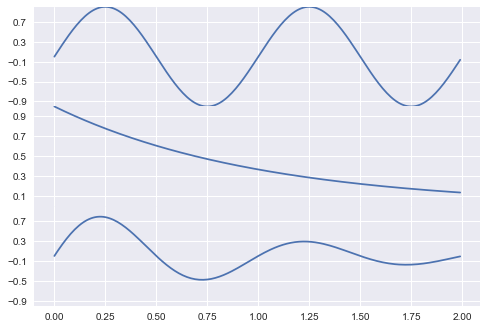

In [8]:
t = np.arange(0.0, 2.0, 0.01)
s = np.sin(2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, s)

ax.grid(True, linestyle='-.')
ax.tick_params(labelcolor='r', labelsize='medium', width=3)

plt.show()